In [542]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import scipy.stats as sps

sns.set()

print ('!!!!! RUN new_york_data to update the info before running this one !!!!!')

!!!!! RUN new_york_data to update the info before running this one !!!!!


In [543]:
dick = pd.read_pickle('us_state_dict.pkl')


In [544]:
df = pd.DataFrame()

def get_latest_numbers(df,statename):
    state = dick[statename]
    last_row = pd.DataFrame(state.iloc[-1]).T
    last_row['state'] = statename
    df = pd.concat([df,last_row],axis=0)
    return df

    

In [545]:
for key,data in dick.items():
    df = get_latest_numbers(df,key)
    
df.sort_values('dead_per_M',inplace=True,ascending=False)
df.head(40)

,confirmed,deceased,recovered,inc,dead_inc,factor,dead_factor,density,population,growth,gdp,conf_per_M,dead_per_M,state
2020-04-01,83948.0,1941.0,0.0,8115.0,391.0,1.107011,1.252258,1068.424744,19440469.0,-0.0052,89076.0,4318.208578,99.843270,New York
2020-04-01,6424.0,273.0,0.0,1187.0,34.0,1.226656,1.142259,278.469047,4645184.0,-0.0032,56836.0,1382.937683,58.770546,Louisiana
2020-04-01,22255.0,355.0,0.0,3559.0,88.0,1.190362,1.329588,3147.351220,8936574.0,0.0031,72850.0,2490.327949,39.724396,New Jersey
2020-04-01,9315.0,335.0,0.0,1700.0,76.0,1.223244,1.293436,460.151533,10045029.0,0.0049,54420.0,927.324351,33.349829,Michigan
2020-04-01,5608.0,234.0,0.0,176.0,9.0,1.032401,1.040000,303.876053,7797095.0,0.0347,80123.0,719.242231,30.011177,Washington
2020-04-01,321.0,16.0,0.0,28.0,3.0,1.095563,1.230769,176.485934,628061.0,0.0028,55841.0,511.096852,25.475233,Vermont
2020-04-01,3557.0,85.0,0.0,429.0,16.0,1.137148,1.231884,1905.891702,3563077.0,-0.0027,80489.0,998.294452,23.855785,Connecticut
2020-04-01,7738.0,122.0,0.0,1118.0,33.0,1.168882,1.370787,2316.577310,6976597.0,0.0108,86798.0,1109.136732,17.487036,Massachusetts
2020-04-01,4638.0,139.0,0.0,709.0,28.0,1.180453,1.252252,483.478001,10736059.0,0.0206,58921.0,432.002097,12.947023,Georgia
2020-04-01,586.0,9.0,0.0,91.0,0.0,1.183838,1.000000,30599.520715,720687.0,0.0260,209260.0,813.113044,12.488084,District of Columbia


In [546]:
df.describe()

,confirmed,deceased,recovered,inc,dead_inc,factor,dead_factor,density,population,growth,gdp,conf_per_M,dead_per_M
count,51.000000,51.000000,51.0,51.000000,51.000000,51.000000,49.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,51.000000
mean,4172.960784,92.921569,0.0,492.960784,17.235294,1.134003,1.210052,1117.736584,6.496451e+06,0.010941,64468.529412,473.910500,10.687405
std,12005.305057,277.011613,0.0,1243.224146,56.241831,0.067574,0.193655,4266.295547,7.450657e+06,0.013758,23600.489132,682.070120,16.899611
min,129.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,3.331502,5.670250e+05,-0.018500,40012.000000,107.419843,0.000000
25%,426.500000,9.000000,0.0,28.500000,1.000000,1.095476,1.080000,131.065960,1.802113e+06,0.001650,53364.000000,175.928385,3.136331
50%,1073.000000,22.000000,0.0,136.000000,2.000000,1.145144,1.192308,279.847438,4.499692e+06,0.007500,60045.000000,261.457190,4.928385
75%,3269.500000,67.500000,0.0,377.000000,10.500000,1.187744,1.259259,580.113566,7.587794e+06,0.022500,68820.500000,450.345373,10.505704
max,83948.000000,1941.000000,0.0,8115.000000,391.000000,1.269366,2.000000,30599.520715,3.993749e+07,0.041000,209260.000000,4318.208578,99.843270


In [547]:
df['mortality'] = df['deceased'] / df['confirmed']
df.head(40)

,confirmed,deceased,recovered,inc,dead_inc,factor,dead_factor,density,population,growth,gdp,conf_per_M,dead_per_M,state,mortality
2020-04-01,83948.0,1941.0,0.0,8115.0,391.0,1.107011,1.252258,1068.424744,19440469.0,-0.0052,89076.0,4318.208578,99.843270,New York,0.023121
2020-04-01,6424.0,273.0,0.0,1187.0,34.0,1.226656,1.142259,278.469047,4645184.0,-0.0032,56836.0,1382.937683,58.770546,Louisiana,0.042497
2020-04-01,22255.0,355.0,0.0,3559.0,88.0,1.190362,1.329588,3147.351220,8936574.0,0.0031,72850.0,2490.327949,39.724396,New Jersey,0.015951
2020-04-01,9315.0,335.0,0.0,1700.0,76.0,1.223244,1.293436,460.151533,10045029.0,0.0049,54420.0,927.324351,33.349829,Michigan,0.035963
2020-04-01,5608.0,234.0,0.0,176.0,9.0,1.032401,1.040000,303.876053,7797095.0,0.0347,80123.0,719.242231,30.011177,Washington,0.041726
2020-04-01,321.0,16.0,0.0,28.0,3.0,1.095563,1.230769,176.485934,628061.0,0.0028,55841.0,511.096852,25.475233,Vermont,0.049844
2020-04-01,3557.0,85.0,0.0,429.0,16.0,1.137148,1.231884,1905.891702,3563077.0,-0.0027,80489.0,998.294452,23.855785,Connecticut,0.023897
2020-04-01,7738.0,122.0,0.0,1118.0,33.0,1.168882,1.370787,2316.577310,6976597.0,0.0108,86798.0,1109.136732,17.487036,Massachusetts,0.015766
2020-04-01,4638.0,139.0,0.0,709.0,28.0,1.180453,1.252252,483.478001,10736059.0,0.0206,58921.0,432.002097,12.947023,Georgia,0.029970
2020-04-01,586.0,9.0,0.0,91.0,0.0,1.183838,1.000000,30599.520715,720687.0,0.0260,209260.0,813.113044,12.488084,District of Columbia,0.015358


In [548]:
def standardize(n):
    return (n - n.mean()) / n.std()


def regression(x,y):
    
    alpha_mu = 0
    alpha_sigma = 1
    
    beta_mu = 1
    beta_sigma = 1
    
    alpha = pm.Normal('alpha',mu=alpha_mu,tau=1 / alpha_sigma ** 2)
    beta = pm.Normal('beta',mu=beta_mu, tau=1 / beta_sigma ** 2)
    obs_sigma = pm.Uniform('obs_sigma',0.1,1) # determines how much spread on the lines there is
    
    #### PRIOR SIMULATION
    N = 100000

    alpha_prior = [alpha.random() for i in range(N)]
    beta_prior = [beta.random() for i in range(N)]
    
    alphas = np.random.choice(alpha_prior,replace=True,size=100)
    betas = np.random.choice(beta_prior,replace=True,size=100)
    
    X = np.linspace(0,7,100)
    
    #plt.figure()
    #plt.title('Prior seeing data')
    #plt.plot(X,[X[i] * betas + alphas for i in range(len(X))],color='r',alpha=0.1)
    ####
    
    
    @pm.deterministic()
    def linreq(x=x,y=y,alpha=alpha,beta=beta):
        return x * beta + alpha
    
    
    obs = pm.Normal('obs',mu=linreq,tau=1/obs_sigma ** 2,observed=True,value=y)
    
    model = pm.Model([alpha,beta,obs_sigma,linreq])
    
    map_ = pm.MAP(model)
    map_.fit()
    
    mcmc = pm.MCMC(model)
    
    samples = mcmc.sample(10000,5000,2)
    
    alpha_post = mcmc.trace('alpha')[:]
    beta_post = mcmc.trace('beta')[:]
    obs_sigma_post = mcmc.trace('obs_sigma')[:]
    linreq_post = mcmc.trace('linreq')[:,0]
    
    result = pd.DataFrame({'alpha_post': alpha_post,
                          'beta_post': beta_post,
                          'obs_sigma_post': obs_sigma_post,
                          'linreq_post' : linreq_post})
    
    print (linreq_post.shape)
    
    return result
    
    
    


 [-----------------100%-----------------] 10000 of 10000 complete in 8.4 sec(2500,)

        alpha_post    beta_post  obs_sigma_post  linreq_post
count  2500.000000  2500.000000     2500.000000  2500.000000
mean     -0.000907     0.489236        0.872611     0.380767
std       0.043950     0.125261        0.069263     0.107346
min      -0.168441     0.089633        0.684475     0.029336
25%      -0.000623     0.408396        0.822395     0.311471
50%       0.000012     0.488191        0.875429     0.378561
75%       0.000292     0.571310        0.927353     0.448953
max       0.185459     0.936019        0.999876     0.836307


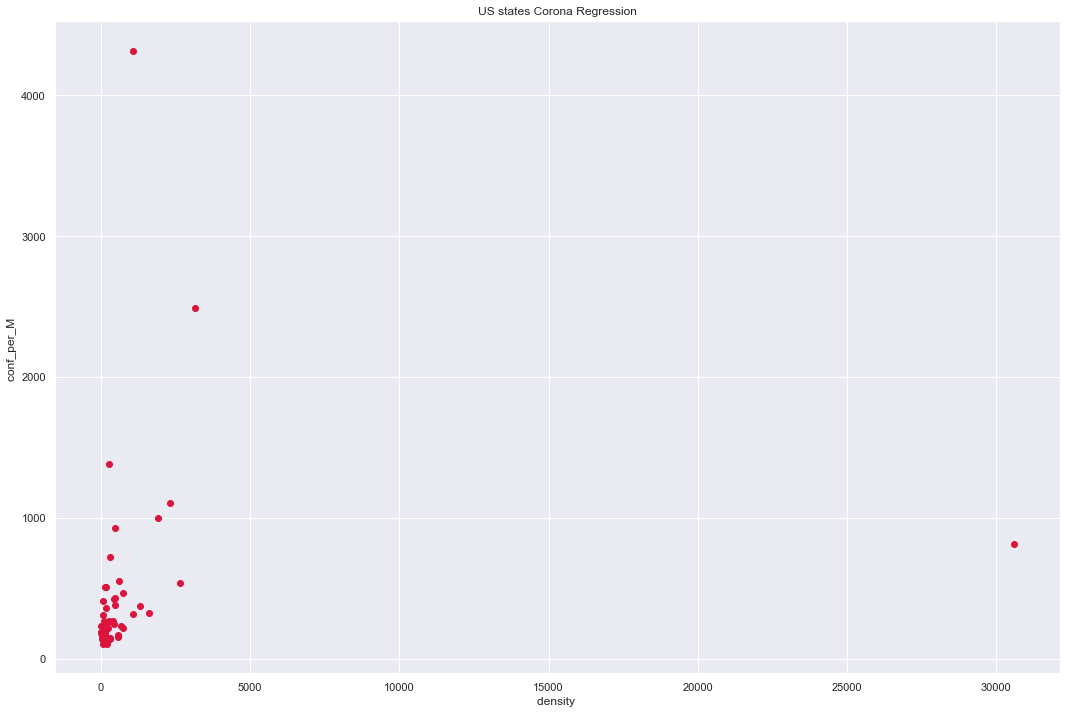

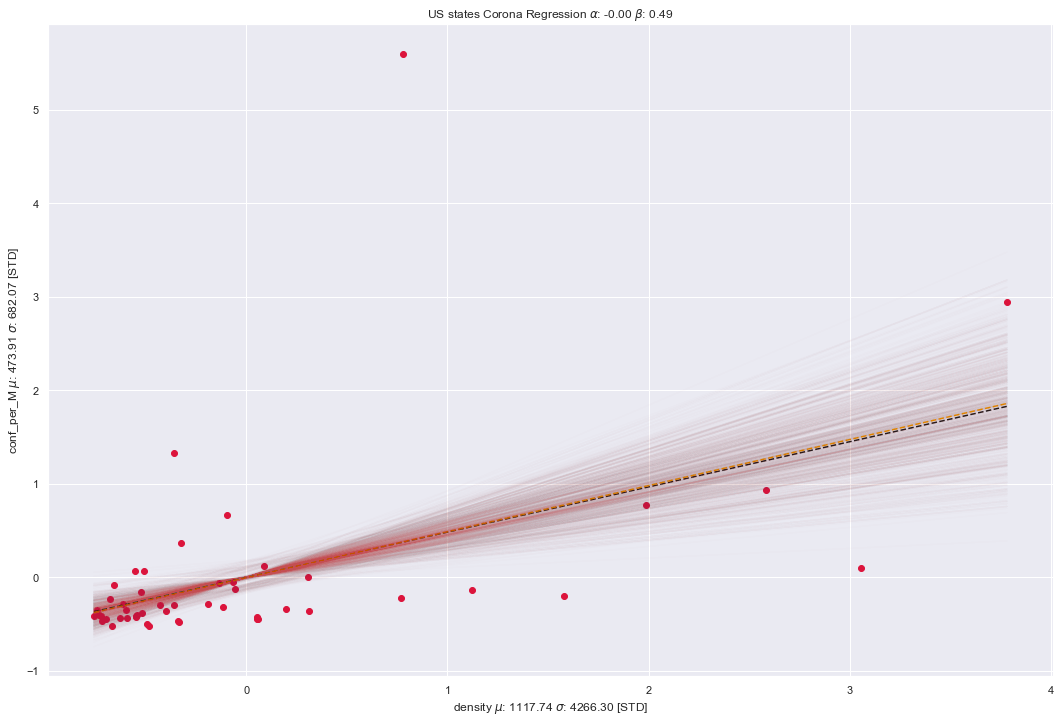

In [549]:
y_param = 'conf_per_M'
x_param = 'density'

x_orig_mean = df[x_param].mean()
x_orig_std = df[x_param].std()
y_orig_mean = df[y_param].mean()
y_orig_std = df[y_param].std()

x = df[x_param]
y = df[y_param]

#### Scatter data ####
plt.figure(figsize=(18,12))
plt.title('US states Corona Regression')
plt.xlabel(x_param + ' ')
plt.ylabel(y_param + ' ')
plt.scatter(x,y,color='crimson')

plt.savefig('US_states_scatter_{}_{}.jpg'.format(x_param,y_param))

#### EXTREME OUTLIERS ####
df = df[df.loc[:,'state'] != 'District of Columbia']
#df = df[df.loc[:,'state'] != 'New York']
####

x = standardize(df[x_param])
y = standardize(df[y_param])
####

slope,intercept,_,_,_ = sps.linregress(x,y)

####

####

result = regression (x,y)
print()
print (result.describe())

X = np.linspace(min(x),max(x),1000)

alpha_samples = np.random.choice(result.alpha_post,replace=True,size=len(X))
beta_samples = np.random.choice(result.beta_post,replace=True,size=len(X))

alpha_mean = alpha_samples.mean()
alpha_std = alpha_samples.std()
beta_mean = beta_samples.mean()
beta_std  = beta_samples.std()

plt.figure(figsize=(18,12))
plt.title(r'US states Corona Regression $\alpha$: {:.2f} $\beta$: {:.2f}'.format(alpha_mean,beta_mean))
plt.xlabel(x_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} [STD]'.format(x_orig_mean,x_orig_std))
plt.ylabel(y_param + r' $\mu$: {:.2f} $\sigma$: {:.2f} [STD]'.format(y_orig_mean,y_orig_std))
plt.scatter(x,y,color='crimson')
plt.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='k',ls='dashed')
plt.plot(X,[X[i] * beta_mean + alpha_mean for i in range(len(X))],color='orange',ls='dashed')

lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])

_ = plt.plot(X,lines,color='r',alpha=0.01)

plt.savefig('US_states_regression_{}_{}.jpg'.format(x_param,y_param))

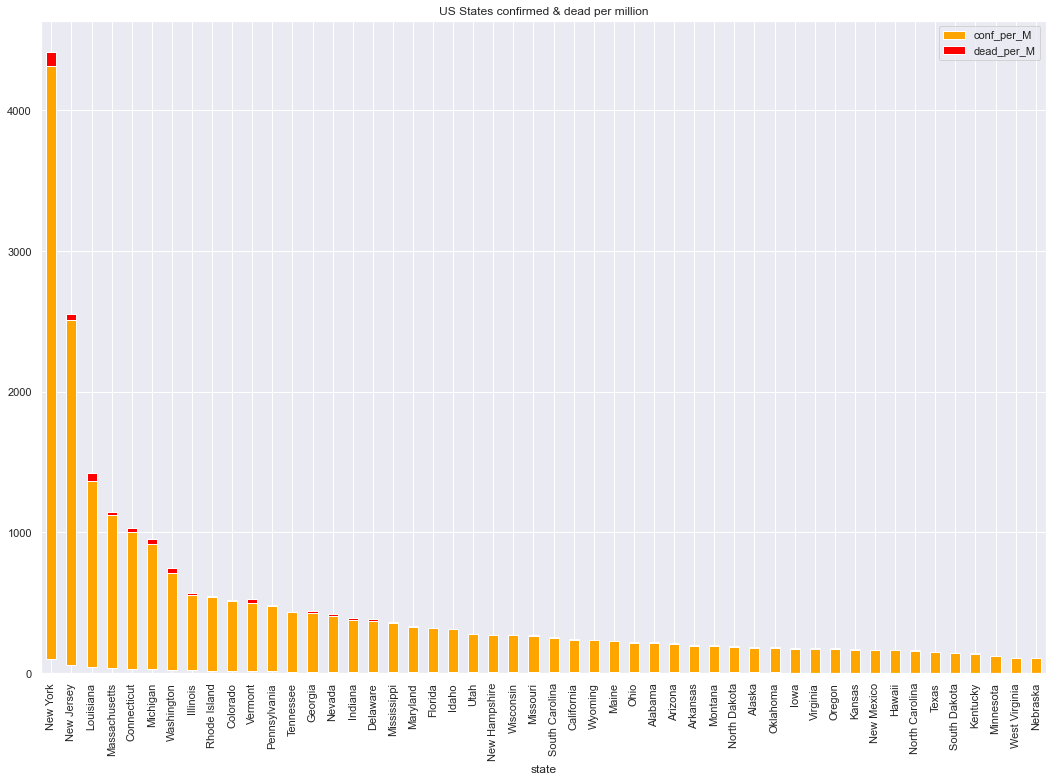

In [550]:
colors = ['orange','red']

temp = df.copy()

temp['conf_per_M'] -= temp['dead_per_M']

bottom = temp['dead_per_M']

temp.sort_values('conf_per_M',ascending=False).plot(
    kind='bar',x='state',y=['conf_per_M','dead_per_M'],figsize=(18,12),color=colors,
title='US States confirmed & dead per million',stacked=True,bottom=bottom)

plt.savefig('US_states_conf_per_M.jpg',format='jpg')